# Supervised Learning Final Project

## Covid-19 Data Analysis


### Introduction (Learning Problem Description)
Covid-19 has changed the lives of everyone in one form or another. The unprecedented spread of the virus has been tracked and catgeorized since the start. The availability and transparency of Covid-19 data has been fundamental in policy decision making. In this project, historical covid-19 data was analyzed in order to answer questions and provide insights into the spread of the disease. The data used was from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) (https://github.com/CSSEGISandData/COVID-19). Please see code for URL to exact dataset used.

With any data analysis it is important to have a relative set of questions or goals that should be answered. Data is meaningless without a relative question to connect it together. Since the scope of the data set is massive, I have decided to focus on some country wide generalizations, and more specifically statewide data. My homestate of Virginia was selected to be the state of interest in the analysis.

Project Github Repository: https://github.com/menonshyam15/Supervised-Learning-Final-Project


### Outline
**Part 1 - Data Prep and Cleaning**

**Part 2 - Exploratory Analysis**

1. What is the current number of Covid-19 cases in the USA?
2. Which states had the highest and lowest number of Covid-19 cases?
3. Visualize the number of Covid-19 cases per state.
4. What is the total number of cases in Virginia?
5. How many new cases have been reported in Virginia over the past 10 days?
6. Which county in Virginia reported the highest number of total cases?
7. When did Fairfax County report the highest number of new Covid-19 cases (in a day)?
8. What is the distribution over time of total number of cases for Fairfax and Arlington counties?

**Part 3 - Model Building/Training and Result**

1. Simple time series for the number of covid-19 cases over time:
    - Virginia
    - USA
2. Build a Linear Regression model to predict number of cases in USA over time (January 2021 to Present)

**Part 4 - Discussion/Conclusion**

<p>&nbsp;</p>

In [1]:
#Preparing the notebook, importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_columns', None)

### Part 1 - Data Prep and Cleaning

In [2]:
#importing the data and preparing the dataframes
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

#list of null values to search for
a = [np.nan, None, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

df = pd.read_csv(url, na_values = a)

# melt and reshape data
df = df.melt(id_vars=['UID', 
                      'iso2',
                      'iso3',
                      'code3',
                      'FIPS',
                      'Admin2',
                      'Province_State',
                      'Country_Region',
                      'Lat',
                      'Long_',
                      'Combined_Key'],
                var_name ='date',
                value_name = "cases")


#subsetting the data into USA
usa = df[df.iso3 == 'USA'].copy()

# convert date to datetime object
usa['date'] = pd.to_datetime(usa.date)

#subsetting the data into Virginia
va = usa.loc[usa['Province_State'] == "Virginia"]

In [3]:
# including the head for people to see the beginning of the dataframe
# please refer to Johns Hopkins Github for field description of data set

usa.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,cases
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",2020-01-22,0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",2020-01-22,0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",2020-01-22,0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",2020-01-22,0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",2020-01-22,0


In [4]:
# including the tail for people to see the end of the dataframe
# please refer to Johns Hopkins Github for field description of data set

usa.tail()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,cases
2569993,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",2022-02-28,9782
2569994,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",2022-02-28,5623
2569995,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",2022-02-28,0
2569996,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",2022-02-28,2337
2569997,84056045,US,USA,840,56045.0,Weston,Wyoming,US,43.839612,-104.567488,"Weston, Wyoming, US",2022-02-28,1548


#### Analysis regarding cleaning data: 

After deeply exploring the data it was found that there were some non-traditional "junk" values. Some of the rows within USA were found to have "unassigned" location values and only a case number. Since there is no way to determine where these data points came from, and they were only a small (<5%) percent of the data, the rows with "unassigned" locations were dropped. Another type of irrelevant/null data was found when exploring the Admin2 column. Upon further exploration (and a google search) it was found that there were covid-19 case counts from two cruise ships (Diamond Princess and Grand Princess)! Once again, since it only represented a small (<5%) percent of the data and since we wanted to focus on the USA spread of cases, these data points were also dropped.

In [5]:
#Cleaning the data

## It was really interesting to see the different types of "junk" in the data. There were many rows of unassigned

#getting rid of "unassigned" locations
usa = usa[usa.Admin2 != "Unassigned"]

#finding null values within Admin2
usa_null = usa[usa.Admin2.isnull()]
print(usa_null.Province_State.unique())

#dropping Diamond Princess and Grand Princess (cruise ships)
usa = usa.dropna(subset=['Admin2'])

['Diamond Princess' 'Grand Princess']


### Part 2 - Exploratory Analysis


#### 1. What is the current number of Covid-19 cases in the USA?

In [6]:
usa_latest = usa[usa.date == usa.date.max()]

#current number of covid cases by state
state_current_cases = usa_latest.groupby(['Province_State'],as_index=False).cases.sum()

#current total number of cases in the USA
current_usa_total = state_current_cases['cases'].sum()

print("The current total number of Covid-19 cases in the United States is:", current_usa_total, "cases")

The current total number of Covid-19 cases in the United States is: 78106056 cases


#### 2. Which states had the highest and lowest number of Covid-19 cases?

In [7]:
highest_state = state_current_cases[state_current_cases['cases']==state_current_cases['cases'].max()]
lowest_state = state_current_cases[state_current_cases['cases']==state_current_cases['cases'].min()]

print(highest_state.Province_State.values, "had the highest number of covid-19 cases with", highest_state.cases.values, "cases.")
print(lowest_state.Province_State.values, "had the lowest number of covid-19 cases with", lowest_state.cases.values, "cases.")

['California'] had the highest number of covid-19 cases with [8972750] cases.
['Vermont'] had the lowest number of covid-19 cases with [98336] cases.


#### 3. Visualize the number of covid-19 cases per state.
Note: Scale of number of cases is per million.

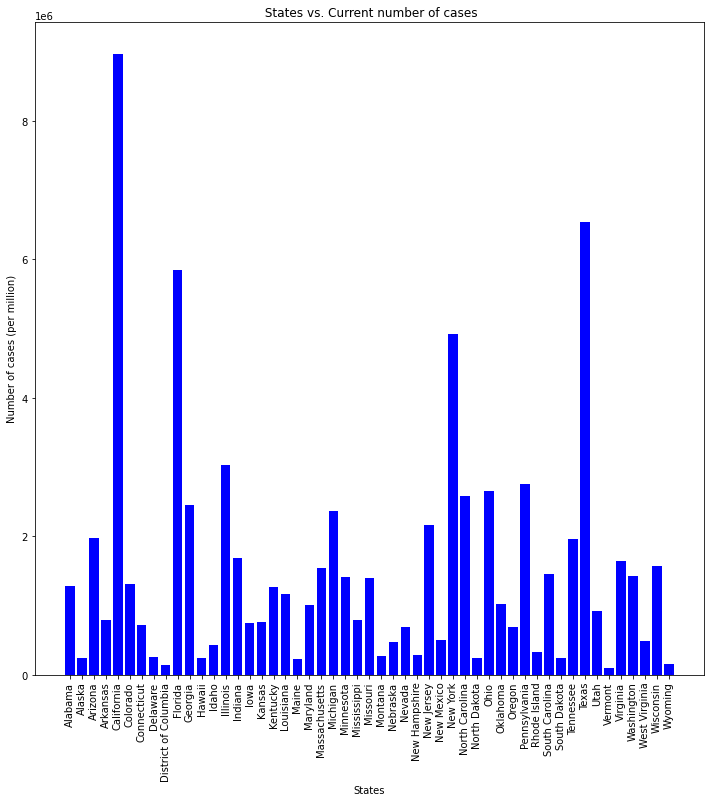

In [8]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(state_current_cases.Province_State,
       state_current_cases.cases,
       color='blue')

# Set title and labels for axes
ax.set(xlabel="States",
       ylabel="Number of cases (per million)",
       title=" States vs. Current number of cases")
plt.xticks(rotation=90)

plt.show()

#### 4. What is the total number of cases in Virginia?

In [9]:
# convert date to datetime object
va['date'] = pd.to_datetime(va.date)

# subsetting specific date
valatest = va[va.date == va.date.max()]

#total number of reported COVID-19 cases in the Virginia
current_va_total = valatest['cases'].sum()

print("The current total number of Covid-19 cases in the state of Virginia is:", current_va_total, "cases")

The current total number of Covid-19 cases in the state of Virginia is: 1639942 cases


#### 5. How many new cases have been reported in Virginia over the past 10 days?

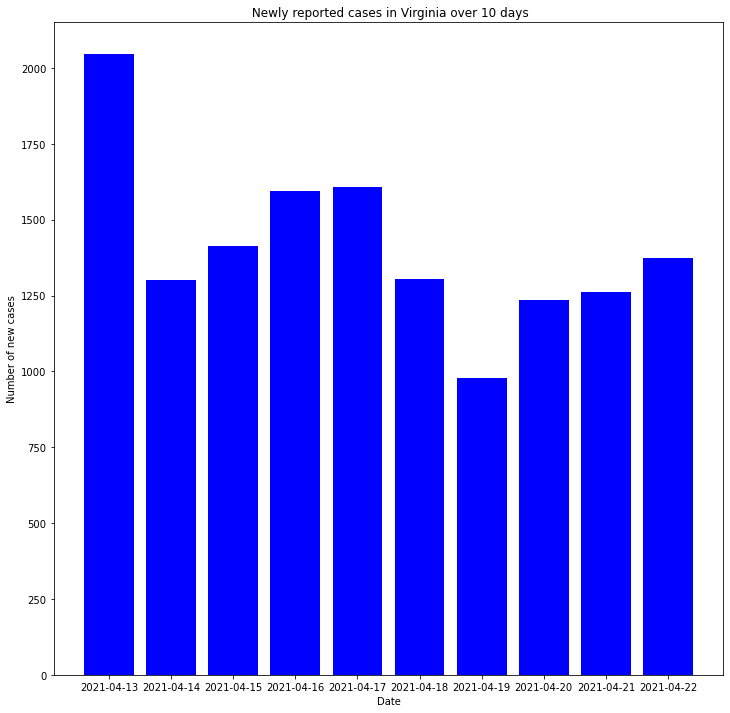

In [10]:
#Newly reported cases in Virginia over 10 days

# Virginia cases over the past 10 days
valast10days = va[(va['date'] >= '2021-04-12') & (va['date'] <= '2021-04-22')]

# Subsetting dates and cases
plotdata = pd.DataFrame({'dates': valast10days['date'], 'cases': valast10days['cases']})

# Group by date and calculate new cases
plotdata = plotdata.groupby(pd.Grouper(key='dates',freq='D')).sum().diff()

# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(plotdata.index.values,
       plotdata['cases'],
       color='blue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of new cases",
       title=" Newly reported cases in Virginia over 10 days")

plt.show()

#### 6. Which county in Virginia reported the highest number of total cases?

In [11]:
#Which Virginia county reported the highest number of total cases?

# Subsetting to county level
vacounty = va[["Admin2","cases"]].copy()
vacounty.set_index('Admin2', inplace=True)

# Display county with highest number of total cases
highest_county_name = vacounty.idxmax().to_string(index=False)
max_county_case = vacounty.max().to_string(index=False)

print(highest_county_name + ' county has the highest number of total cases with ' + max_county_case + ' cases.')

 Fairfax county has the highest number of total cases with  172659 cases.


#### 7. When did Fairfax County report the highest number of new Covid-19 cases (in a day)?

In [12]:
#When did Fairfax county report the highest number of new COVID-19 cases in a day?

ffxcounty = va[["Admin2", "date", "cases"]].copy()
ffxcounty = ffxcounty[ffxcounty.Admin2 == "Fairfax"].copy()

ffxcounty = ffxcounty.groupby(pd.Grouper(key='date',freq='D')).sum().diff()

max_ffxcounty_case = ffxcounty.max().to_string(index=False)
highest_ffxcounty_date = ffxcounty.idxmax().to_string(index=False)

print('Fairfax County had the highest number of new COVID-19 cases (' + max_ffxcounty_case + ') on ' + highest_ffxcounty_date + '.')

Fairfax County had the highest number of new COVID-19 cases ( 7655.0) on 2022-01-10.


#### 8. What is the distribution over time of total number of cases for Fairfax and Arlington counties?

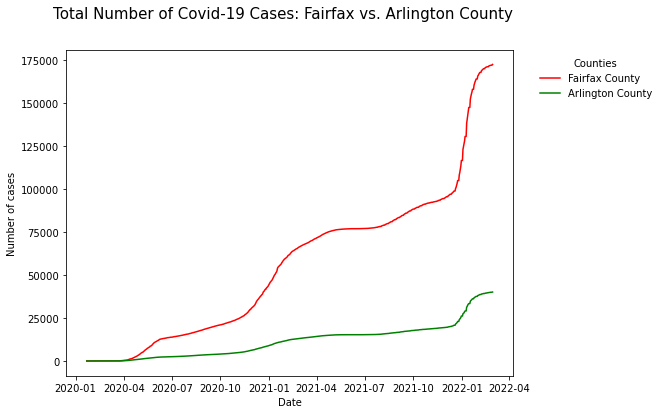

In [13]:
#One figure that shows two plotted lines, 
# where each line represents the total number of cases over time (from the earliest to the most recent date), 
# for Fairfax and Arlington.

# Subsetting needed data
ffxcounty2 = va[["Admin2", "date", "cases"]].copy()
ffxcounty2 = ffxcounty2[ffxcounty2.Admin2 == "Fairfax"].copy()

arlington = va[["Admin2", "date", "cases"]].copy()
arlington = arlington[arlington.Admin2 == "Arlington"].copy()


# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Total Number of Covid-19 Cases: Fairfax vs. Arlington County', fontsize=15)

# Set title and labels for axes
ax.set(xlabel="Date", ylabel="Number of cases")

# Draw all the lines in the same plot, assigning a label for each one to be shown in the legend.
ax.plot(ffxcounty2['date'], ffxcounty2['cases'], color="red", label="Fairfax County")
ax.plot(arlington['date'], arlington['cases'], color="green", label="Arlington County")

# Add a legend, and position it on the lower right (with no box)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Counties", frameon=False)

plt.show()

### Part 3 - Model Building/Training and Result


#### Simple time series for the number of covid-19 cases over time:

###### Virginia from January 2020 to Present

Best-fit Slope: 1873.3919032507645


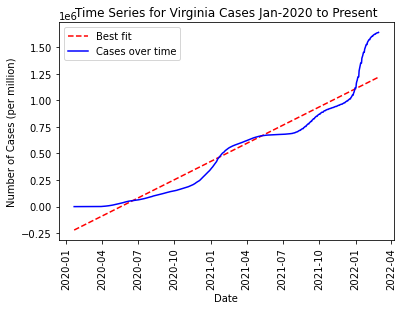

In [14]:
#Virginia simple timeseries
va_grouped = va.groupby(['date'],as_index=False).cases.sum()

x_va = np.arange(va_grouped['date'].size)
fit_va = np.polyfit(x_va, va_grouped['cases'], deg=1)
print ("Best-fit Slope: " + str(fit_va[0]))

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit_va)

#Linear regression plot
plt.plot(va_grouped['date'], fit_function(x_va), '--', color = "red", label = 'Best fit')
#Time series data plot
plt.plot(va_grouped['date'], va_grouped['cases'], color = "blue", label = 'Cases over time')

plt.xlabel('Date')
plt.ylabel('Number of Cases (per million)')
plt.title('Time Series for Virginia Cases Jan-2020 to Present')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Results: The graph above illustrates the spread of covid-19 cases in Virginia over time. As seen there is a positive trend in the growth of covid-19 cases from January 2020 to Present. The rate of growth was found to be 1873 new cases per day.

###### USA from January 2020 to Present

Slope : 91447.06855607616


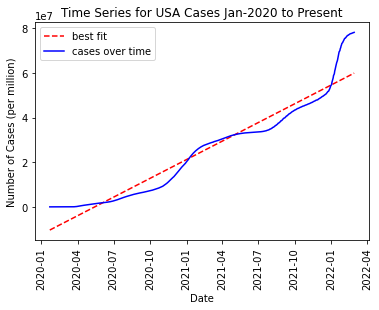

In [15]:
#USA simple timeseries
usa_grouped = usa.groupby(['date'],as_index=False).cases.sum()

x_usa = np.arange(usa_grouped['date'].size)

fit_usa = np.polyfit(x_usa, usa_grouped['cases'], deg=1)
print ("Slope : " + str(fit_usa[0]))

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit_usa)

#Linear regression plot
plt.plot(usa_grouped['date'], fit_function(x_usa),'--', color = "red", label='best fit')
#Time series data plot
plt.plot(usa_grouped['date'], usa_grouped['cases'], color = "blue", label='cases over time')

plt.xlabel('Date')
plt.ylabel('Number of Cases (per million)')
plt.title('Time Series for USA Cases Jan-2020 to Present')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Results: The graph above illustrates the spread of covid-19 cases in all of USA over time. As seen there is a positive trend in the growth of covid-19 cases from January 2020 to Present. The rate of growth was found to be 91,447 new cases per day.

#### Build a Linear Regression model to predict number of cases in USA over time (January 2020 to Present)

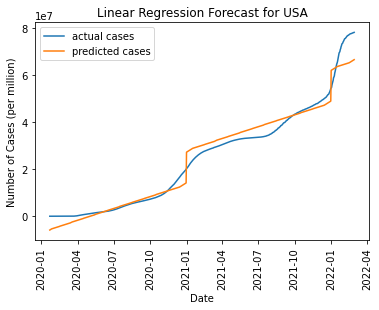

In [16]:
from sklearn.linear_model import LinearRegression

# extract the seasonality data
months = [x.month for x in usa_grouped.date]
years = [x.year for x in usa_grouped.date]
day = [x.day for x in usa_grouped.date]
 
# convert into one matrix
X = np.array([day, months, years]).T
 
# fit the model
my_lr = LinearRegression()
my_lr.fit(X, usa_grouped.cases.values)
 
# predict on the same period
preds = my_lr.predict(X)

pred_usa_grouped = usa_grouped.date

# plot what has been learned
plt.plot(usa_grouped.date, usa_grouped.cases.values, label = "actual cases")
plt.plot(np.sort(pred_usa_grouped), np.sort(preds), label = "predicted cases")
plt.xticks(rotation=90)
plt.title("Linear Regression Forecast for USA")
plt.xlabel('Date')
plt.ylabel('Number of Cases (per million)')
plt.legend()
plt.show()

Results: The graph above illustrates the spread of covid-19 cases in all of USA over time along with a predicted linear regression model. As seen there is a positive trend in the growth of covid-19 cases from January 2020 to Present. The linear model also predicts the same trend; howevever it seems that the model is providing an under-fit estimation compared to the actual cases.

### Part 4 - Discussion / Conclusion

Navigating large data sets can often be difficult due to their size. One of the biggest steps in data analysis is the cleaning of data. In order to have quality visualizations, the data must be organized and clean of unwanted values. Majority of the time was spent cleaning and subsetting the large data set to narrow the scope to the questions of interest. It was interesting to see how COVID-19 spread, both nationwide in the US and in the state of Virginia. Historical analysis was able to provide peaks and fluctuations of COVID-19 spread. The linear regression model was able to predict based on the historical data; however, it provided an under-fit estimation. Further analysis must be done in order to tweak the model for better fit or selection of another model may provide a better solution. Nonetheless, the visualizations that were created was able to summarize the data in a meaningful manner. Trends and insights were easily readable once visualized.

Without a doubt Covid-19 has changed the lives of everyone in one form or another. In the coming years, continuous tracking and monitoring of the virus will be necessary in order to provide data/science driven decision making policies. Future policies should be devleoped in full transparancy and with the goal of benefitting the general public health domain.